<a href="https://colab.research.google.com/github/luvnz/ISYS5002_2023_s2/blob/main/Cardiovascular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up the environment
Import the necessary libraries:

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

 # Access the database
 The cardiohealth SQLite database have been uploaded to the Colab notebook or available in GitHub repo.

In [ ]:
# Connect to the cardiohealth SQLite database
conn = sqlite3.connect("cardiohealth.db")


def querydb(query):
    return pd.read_sql_query(query, conn)


# Examine the schema of the database
tables = querydb("SELECT name FROM sqlite_master WHERE type='table';")
# Check available tables in database
print(tables)

                  name
0  medical_examination


Once we have the list of tables, we can explore the structure of the table using:

In [ ]:
table = "medical_examination"
schema = querydb(f"PRAGMA table_info({table});")
print(schema)

    cid         name     type  notnull dflt_value  pk
0     0           id  INTEGER        0       None   0
1     1          age  INTEGER        0       None   0
2     2       gender  INTEGER        0       None   0
3     3       height  INTEGER        0       None   0
4     4       weight     REAL        0       None   0
5     5        ap_hi  INTEGER        0       None   0
6     6        ap_lo  INTEGER        0       None   0
7     7  cholesterol  INTEGER        0       None   0
8     8         gluc  INTEGER        0       None   0
9     9        smoke  INTEGER        0       None   0
10   10         alco  INTEGER        0       None   0
11   11       active  INTEGER        0       None   0
12   12       cardio  INTEGER        0       None   0


This data table has thirteen columns, where the id column is the row number. This data table has 13 columns, the id column is the row number, and the cardio column indicates whether there is cardiovascular disease.

The dataset provides insights into individuals' cardiovascular health, capturing discrete features like gender, cholesterol level, glucose level, smoking status, alcohol consumption, and physical activity status, alongside continuous metrics including height, weight, systolic, and diastolic blood pressures.

# Data extraction and manipulation


Now we extract the data table, which has 70,000 samples.

In [ ]:
data = pd.read_sql_query(f"SELECT * FROM {table}", conn)
print(data)

          id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
0          0  18393       2     168    62.0    110     80            1     1   
1          1  20228       1     156    85.0    140     90            3     1   
2          2  18857       1     165    64.0    130     70            3     1   
3          3  17623       2     169    82.0    150    100            1     1   
4          4  17474       1     156    56.0    100     60            1     1   
...      ...    ...     ...     ...     ...    ...    ...          ...   ...   
69995  99993  19240       2     168    76.0    120     80            1     1   
69996  99995  22601       1     158   126.0    140     90            2     2   
69997  99996  19066       2     183   105.0    180     90            3     1   
69998  99998  22431       1     163    72.0    135     80            1     2   
69999  99999  20540       1     170    72.0    120     80            2     1   

       smoke  alco  active  cardio  
0 

Check the missing number of variables. Acturally we don't miss any values.

To clean the data DataFrame by setting values outside the typical range to NaN, you can use the following conditions based on the dataset description you provided:

- Age: We assume that any age below 0 is invalid. An upper bound for age isn't defined, but let's assume that 120 years (or 43800 days) is the maximum reasonable age.
- Gender: Should be 1 or 2.
- Height: Let's assume a range of 100 cm to 250 cm.
- Weight: Let's assume a range of 30 kg to 250 kg.
- Blood pressure (ap_hi & ap_lo): We'll use a reasonable range of 50 to 250 for systolic and 30 to 180 for diastolic.
- Cholesterol & Glucose: Values should be in the range 1-3.
- Smoke, Alco, Active, and Cardio: Should be binary values (0 or 1).


In [ ]:
print(data.isna().sum().sum())

# Set values outside of bounds to NaN
data.loc[(data['age'] < 0) | (data['age'] > 43800), 'age'] = np.nan
data.loc[(data['gender'] < 1) | (data['gender'] > 2), 'gender'] = np.nan
data.loc[(data['height'] < 100) | (data['height'] > 250), 'height'] = np.nan
data.loc[(data['weight'] < 30) | (data['weight'] > 250), 'weight'] = np.nan
data.loc[(data['ap_hi'] < 50) | (data['ap_hi'] > 250), 'ap_hi'] = np.nan
data.loc[(data['ap_lo'] < 30) | (data['ap_lo'] > 180), 'ap_lo'] = np.nan
data.loc[(data['cholesterol'] < 1) | (data['cholesterol'] > 3), 'cholesterol'] = np.nan
data.loc[(data['gluc'] < 1) | (data['gluc'] > 3), 'gluc'] = np.nan
data.loc[(data['smoke'] < 0) | (data['smoke'] > 1), 'smoke'] = np.nan
data.loc[(data['alco'] < 0) | (data['alco'] > 1), 'alco'] = np.nan
data.loc[(data['active'] < 0) | (data['active'] > 1), 'active'] = np.nan
data.loc[(data['cardio'] < 0) | (data['cardio'] > 1), 'cardio'] = np.nan

print(data.isna().sum())

0
id                0
age               0
gender           11
height           29
weight            7
ap_hi           228
ap_lo          1009
cholesterol       0
gluc              0
smoke             0
alco              0
active            0
cardio            0
dtype: int64


## 1. Age vs. Cardiovascular Disease:

Chart Description:
This bar chart visualizes the prevalence of cardiovascular disease by age groups. The x-axis represents different age categories, while the y-axis indicates the proportion of people with cardiovascular disease.




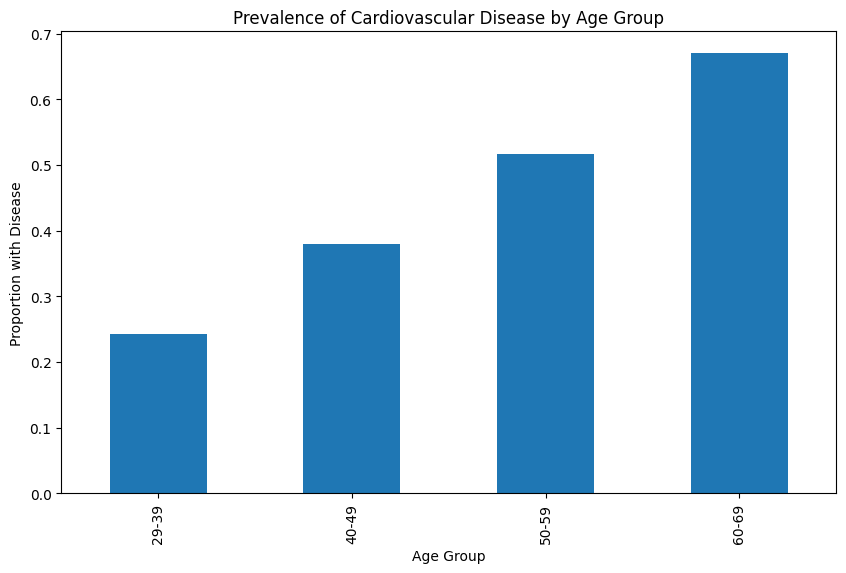

In [ ]:
# Convert age from days to years
data["age_years"] = (data["age"] / 365).astype(int)

# Categorize into age groups
bins = [29, 40, 50, 60, 70]
labels = ["29-39", "40-49", "50-59", "60-69"]
data["age_group"] = pd.cut(data["age_years"], bins=bins, labels=labels, right=False)

# Plot
plt.figure(figsize=(10, 6))
data.groupby("age_group")["cardio"].mean().plot(kind="bar")
plt.title("Prevalence of Cardiovascular Disease by Age Group")
plt.ylabel("Proportion with Disease")
plt.xlabel("Age Group")
plt.show()

Interpretation:
The chart provides insights into the likelihood of having cardiovascular disease across different age groups. A rising bar indicates an increasing trend of cardiovascular disease with age, suggesting that older individuals might be at higher risk.

## 2. Blood Pressure vs. Cardiovascular Disease:

Chart Description:
The bar chart displays the prevalence of cardiovascular disease by systolic blood pressure categories. The x-axis represents systolic blood pressure groups like 'Normal', 'Elevated', and 'High'. The y-axis denotes the proportion of people diagnosed with cardiovascular disease.



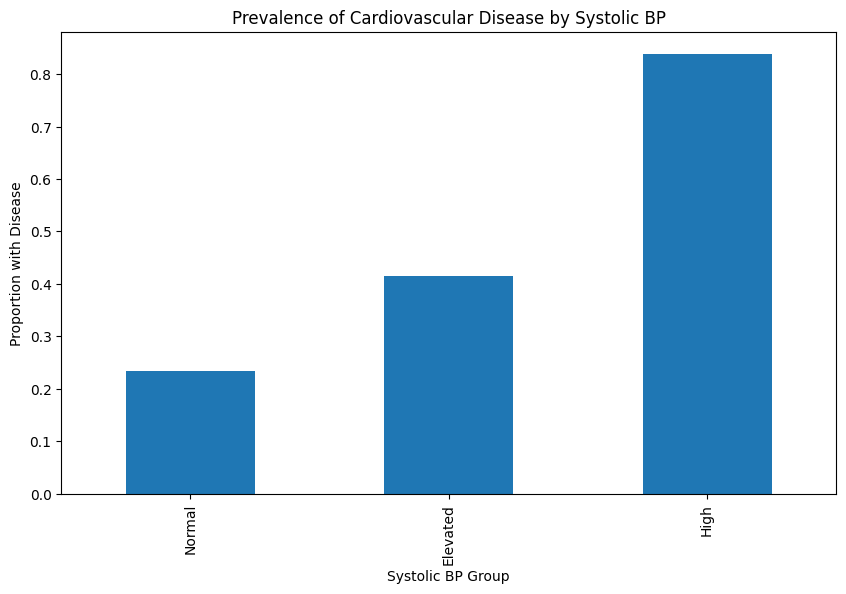

In [ ]:
# Categorize systolic blood pressure
bins_systolic = [50, 120, 140, 250]
labels_systolic = ["Normal", "Elevated", "High"]
data["systolic_bp_group"] = pd.cut(
    data["ap_hi"], bins=bins_systolic, labels=labels_systolic, right=False
)

# Plot
plt.figure(figsize=(10, 6))
data.groupby("systolic_bp_group")["cardio"].mean().plot(kind="bar")
plt.title("Prevalence of Cardiovascular Disease by Systolic BP")
plt.ylabel("Proportion with Disease")
plt.xlabel("Systolic BP Group")
plt.show()

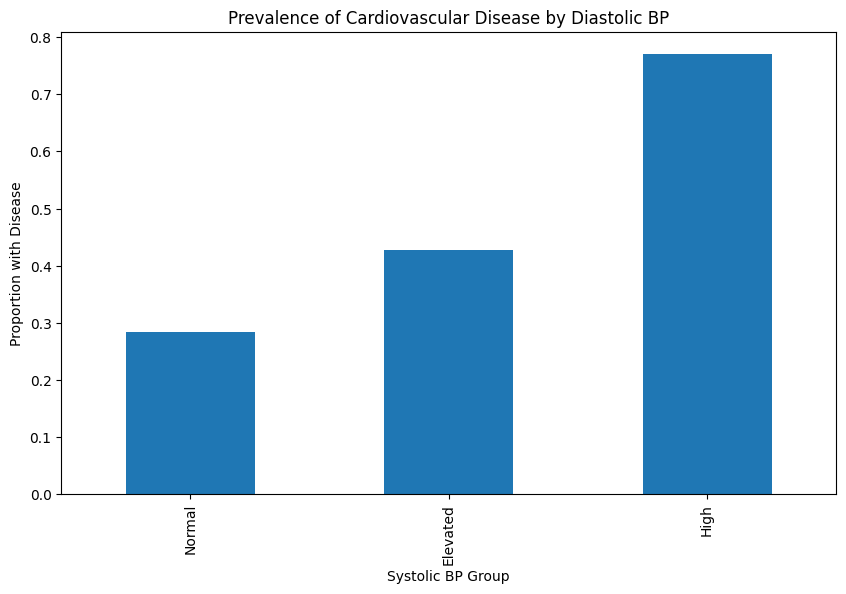

In [ ]:
# Categorize systolic blood pressure
bins_systolic = [30, 80, 90, 180]
labels_systolic = ["Normal", "Elevated", "High"]
data['diastolic_bp_group'] = pd.cut(
    data["ap_lo"], bins=bins_systolic, labels=labels_systolic, right=False
)

# Plot
plt.figure(figsize=(10, 6))
data.groupby('diastolic_bp_group')["cardio"].mean().plot(kind="bar")
plt.title("Prevalence of Cardiovascular Disease by Diastolic BP")
plt.ylabel("Proportion with Disease")
plt.xlabel("Systolic BP Group")
plt.show()

Interpretation:
The chart reveals the relationship between systolic blood pressure levels and cardiovascular disease prevalence. There's an increasing trend. it suggests that individuals with higher systolic blood pressures might have a higher risk of developing cardiovascular disease.

 ## 3. BMI and Cholesterol vs. Cardiovascular Disease

Chart Description:
This line chart presents the prevalence of cardiovascular disease across different BMI categories, segmented by cholesterol levels. The x-axis lists the BMI groups, and the y-axis indicates the proportion of people with cardiovascular disease. Each cholesterol level has its distinct line, with data points for each BMI group.



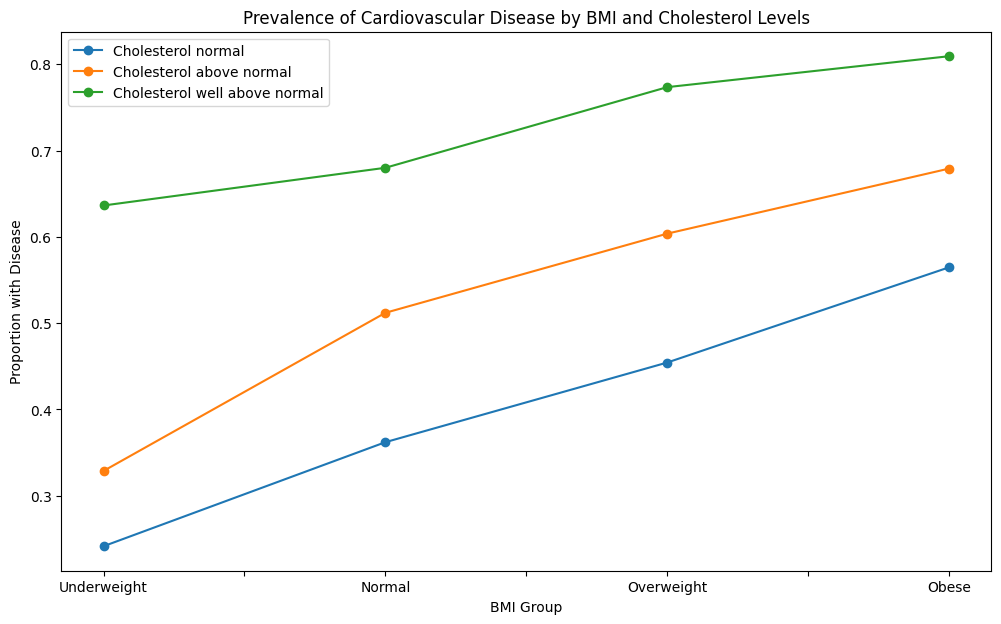

In [ ]:
# Calculate BMI
data["BMI"] = data["weight"] / ((data["height"] / 100) ** 2)

# Categorize BMI
bins_bmi = [14, 18.5, 25, 30, 45]
labels_bmi = ["Underweight", "Normal", "Overweight", "Obese"]
data["bmi_group"] = pd.cut(data["BMI"], bins=bins_bmi, labels=labels_bmi, right=False)

# Plot for BMI and Cholesterol
plt.figure(figsize=(12, 7))
cholesterol = {1: "normal", 2: "above normal", 3: "well above normal"}
for label, v in cholesterol.items():
    subset = data[data["cholesterol"] == label]
    (subset.groupby("bmi_group")["cardio"].mean()).plot(
        label=f"Cholesterol {v}", marker="o"
    )

plt.title("Prevalence of Cardiovascular Disease by BMI and Cholesterol Levels")
plt.ylabel("Proportion with Disease")
plt.xlabel("BMI Group")
plt.legend()
plt.show()

Interpretation:
This chart offers a layered understanding of the interplay between BMI, cholesterol levels, and cardiovascular disease prevalence. The line representing higher cholesterol levels consistently lies above the others across all BMI groups, it suggests that, regardless of BMI, higher cholesterol may be a significant risk factor for cardiovascular disease.
And we can also conclude that higher BMI may also lead to a higher risk.

## 4. Smoking and Physical Activity vs. Cardiovascular Disease:

Chart Description:

The given chart is a side-by-side bar chart that displays the prevalence of cardiovascular disease among smokers and non-smokers, further segmented by their physical activity status.

The x-axis represents smoking status, broken down into two categories: "Non-smoker" and "Smoker."

The y-axis represents the proportion of individuals with cardiovascular disease, ranging from 0 (no individuals with cardiovascular disease) to 1 (all individuals have cardiovascular disease).

The bars themselves are segmented by physical activity status: "Inactive" (those who do not engage in regular physical activity) and "Active" (those who regularly participate in physical activities). For each smoking category, there are two bars side-by-side, allowing for a direct comparison between inactive and active individuals.


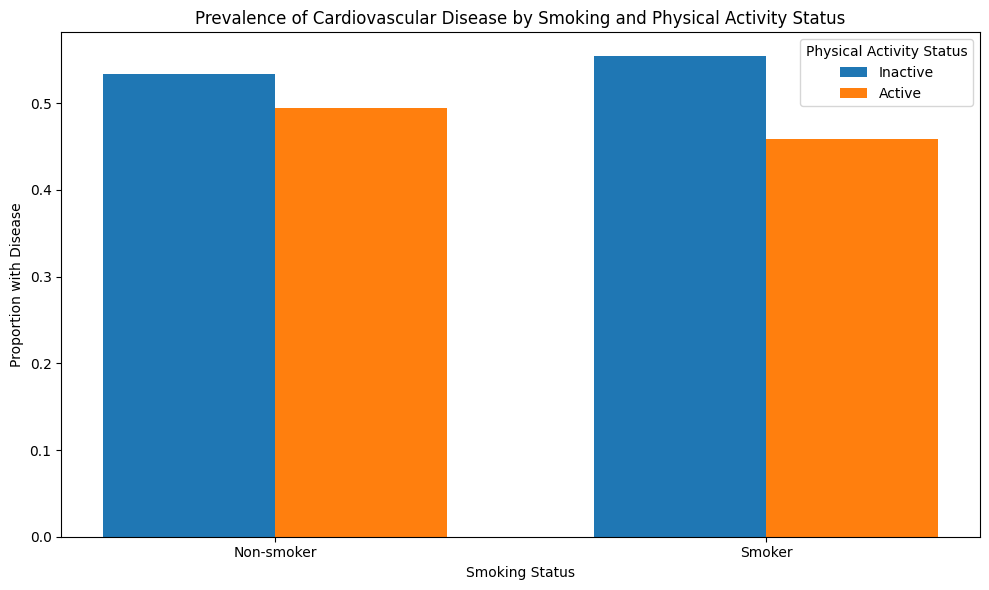

In [ ]:
# Group by Smoking and Physical Activity
grouped_data = data.groupby(["smoke", "active"])["cardio"].mean().reset_index()


plt.figure(figsize=(10, 6))

# Create an array for the positions of the bars on the x-axis
barWidth = 0.35
r1 = np.arange(len(grouped_data["smoke"].unique()))
r2 = [x + barWidth for x in r1]

bars1 = grouped_data[grouped_data["active"] == 0]["cardio"].values
bars2 = grouped_data[grouped_data["active"] == 1]["cardio"].values

plt.bar(r1, bars1, width=barWidth, label="Inactive")
plt.bar(r2, bars2, width=barWidth, label="Active")

plt.title(
    "Prevalence of Cardiovascular Disease by Smoking and Physical Activity Status"
)
plt.ylabel("Proportion with Disease")
plt.xlabel("Smoking Status")
plt.xticks([r + barWidth / 2 for r in range(len(bars1))], ["Non-smoker", "Smoker"])
plt.legend(title="Physical Activity Status")
plt.tight_layout()
plt.show()

The bar representing active smokers is significantly lower than the one for inactive smokers, it could suggest that physical activity might mitigate some of the cardiovascular risks associated with smoking.

On the other hand, the bars for smokers (whether active or inactive) are considerably higher than those for non-smokers, it highlights the potential cardiovascular risks posed by smoking, regardless of one's physical activity status.

# Conclusion

## Summary of Insights:

Age: As individuals grow older, there seems to be a rising tendency for the onset of cardiovascular disease. The data suggests that the elderly population is more susceptible.

Blood Pressure: There's a discernible link between increased systolic blood pressure and a greater likelihood of cardiovascular disease. This upward pattern indicates that those with higher systolic readings might be more vulnerable to cardiovascular ailments.

Cholesterol and BMI: Even when setting aside the influence of Body Mass Index (BMI), higher cholesterol stands out as a potent indicator for cardiovascular disease susceptibility. Moreover, a distinct relationship emerges when assessing BMI alone, highlighting the intertwined nature of BMI and cholesterol in influencing disease risk.

Smoking and Physical Activity: Engaging in physical exercise seems to provide a protective buffer against the cardiovascular threats posed by smoking. However, irrespective of activity levels, smokers generally exhibit a more pronounced risk profile when juxtaposed with non-smokers.

## Limitations and Improvements:

Correlation vs. Causation: The current analysis delineates correlations but doesn't ascertain causative relationships. Controlled studies would be necessary to validate causality.

Population Bias: The dataset might not be representative of broader populations or different ethnic or regional groups. Expanding the dataset's scope or conducting stratified analyses could provide more comprehensive insights.

## Reflection on Python Notebooks

Python notebooks are exceptionally user-friendly platforms that seamlessly combine code execution with data visualization and narrative. Their interactive nature enables real-time feedback, aiding swift data exploration and iterative analysis.

The ability to interleave commentary with code makes Python notebooks an invaluable tool for data-driven storytelling. The integration of code cells with output displays, be it tables or charts, helps in breaking down complex analyses into understandable chunks.

One of the more understated benefits of Python notebooks is their collaborative potential. They can be shared, commented on, and even run by collaborators in real-time, making them ideal for team-basedprojects.